In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import torch

In [2]:
# load dataset
dataset = "dataframe_standardized_outliers_removed_classes.csv"
df = pd.read_csv(dataset) # dataframe in pandas
df['target'] = df['target'].sub(3)# change to 7 classes 0 1 2 3 4 5 6

In [3]:
print(df[df['no'] == 723])
for i in range(720, 729):  ### debug
    df = df[df['no'] != i]
df = df.sample(frac=1) # shuffle

      Unnamed: 0   no  target  t  activity  appCat.builtin  \
2888        2888  723       4  0 -0.499064       -0.032645   
2889        2889  723       4  1  0.989888        0.949300   
2890        2890  723       4  2  0.457188        0.335828   
2891        2891  723       4  3 -0.154787       -0.272890   

      appCat.communication  appCat.entertainment  appCat.finance  appCat.game  \
2888              0.554783             -0.628182       -0.327054    -0.259976   
2889              0.538962             -0.513537       -0.327054    -0.259976   
2890             -0.591393             -0.658839       -0.327054    -0.259976   
2891             -0.855933             -0.658839       -0.327054    -0.259976   

      ...  appCat.travel  appCat.unknown  appCat.utilities  appCat.weather  \
2888  ...        -0.4155       -0.322651         -0.089520        -0.23013   
2889  ...        -0.4155        0.060803         -0.166846        -0.23013   
2890  ...        -0.4155       -0.322651         

In [4]:
# get labels
Y = df['target'].to_numpy()
Y = Y[::4]


In [5]:
# get input 
X = df.iloc[:, 3:].to_numpy()
X = X[:, 1:]
split = len(X[:, 0]) / 4
X = np.array_split(X, split)
X = np.array(X)


In [6]:
# k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

In [7]:
# training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class lstm(nn.Module):
    def __init__ (self, input_size, hidden_size, num_layers, seq_length, output_size):
        super(). __init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.output_size = output_size
        self.hidden_lin_size = 20
        self.ltsm = torch.nn.LSTM(self.input_size, self.hidden_size, batch_first=True) 
        self.lin1 = nn.Linear(self.hidden_size, self.hidden_lin_size) 
        self.lin2 = nn.Linear(self.hidden_lin_size, self.output_size)
        
    def forward(self, x):
        x, (hn, cn) = self.ltsm(x)
        x = F.relu(x) # is this ok?
        x = F.relu(self.lin1(x))  
        x = self.lin2(x)
        return x, (hn, cn)


In [9]:
import torch.optim as optim


In [10]:
test_accuracy = []

# train 10 times FOR STATISTICS
for train_index, test_index in kf.split(X): # K-FOLD CROSS VALIDATION
    net = lstm(input_size=19, hidden_size=100, num_layers=1, seq_length=4, output_size=7).float() # reset NN
    learning_rate = 0.001
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    # split test and train
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # to torch tensor
    x_train = torch.tensor(x_train)
    y_train = torch.tensor(y_train).to(torch.int64)
    x_test = torch.tensor(x_test)
    y_test = torch.tensor(y_test).to(torch.int64)

    # weighted cross entropy
    unique, counts = np.unique(y_train, return_counts=True)
    nSamples = [887, 6130, 480, 317, 972, 101, 128]
    normedWeights = [(1 - (x / sum(counts))) for x in counts]
    normedWeights = torch.FloatTensor(normedWeights).to(device)
    criterion = nn.CrossEntropyLoss(weight=normedWeights)
    
    # train the network
    for epoch in range(8):
        running_loss = 0.0
        net.train()
        for i in range(len(x_train)):
            
            inputs, labels =torch.unsqueeze(x_train[i], 0).to(device).float(), torch.unsqueeze(y_train[i], 0).to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, (hn, cn) = net(inputs)
            output = torch.mean(outputs, dim=1) # takes the average over the outputs 
            loss = criterion(output, labels)
            loss.backward() 
            optimizer.step()
            running_loss += loss.item()

            # statistics tensorboard
            if i % 100 == 99:    # every 30 mini-batches

                # print
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))

                running_loss = 0.0

    print('Finished Training')
    
    
    # validation 
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for i in range(len(x_test)):
            inputs, labels =torch.unsqueeze(x_test[i], 0).to(device).float(), torch.unsqueeze(y_test[i], 0).to(device)
            outputs, (hn, cn) = net(inputs)
            output = torch.mean(outputs, dim=1)  
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    final = 100 * correct / total
    print('Accuracy on the test set: %d %%' % (final))
    test_accuracy.append(final)

[1,   100] loss: 1.916
[1,   200] loss: 1.309
[1,   300] loss: 1.012
[1,   400] loss: 1.245
[1,   500] loss: 1.185
[1,   600] loss: 1.128
[1,   700] loss: 1.078
[1,   800] loss: 1.169
[1,   900] loss: 1.244
[2,   100] loss: 1.208
[2,   200] loss: 1.178
[2,   300] loss: 0.969
[2,   400] loss: 1.164
[2,   500] loss: 1.148
[2,   600] loss: 1.094
[2,   700] loss: 1.006
[2,   800] loss: 1.120
[2,   900] loss: 1.105
[3,   100] loss: 1.178
[3,   200] loss: 1.138
[3,   300] loss: 0.908
[3,   400] loss: 1.028
[3,   500] loss: 1.086
[3,   600] loss: 1.034
[3,   700] loss: 0.960
[3,   800] loss: 1.060
[3,   900] loss: 1.043
[4,   100] loss: 1.128
[4,   200] loss: 1.111
[4,   300] loss: 0.867
[4,   400] loss: 0.952
[4,   500] loss: 1.051
[4,   600] loss: 0.992
[4,   700] loss: 0.919
[4,   800] loss: 1.017
[4,   900] loss: 1.018
[5,   100] loss: 1.106
[5,   200] loss: 1.081
[5,   300] loss: 0.836
[5,   400] loss: 0.913
[5,   500] loss: 1.018
[5,   600] loss: 0.963
[5,   700] loss: 0.881
[5,   800] 

[7,   700] loss: 0.838
[7,   800] loss: 0.850
[7,   900] loss: 0.823
[8,   100] loss: 0.829
[8,   200] loss: 0.938
[8,   300] loss: 0.939
[8,   400] loss: 0.746
[8,   500] loss: 0.771
[8,   600] loss: 0.811
[8,   700] loss: 0.807
[8,   800] loss: 0.778
[8,   900] loss: 0.764
Finished Training
Accuracy on the test set: 59 %
[1,   100] loss: 1.851
[1,   200] loss: 1.301
[1,   300] loss: 1.225
[1,   400] loss: 0.993
[1,   500] loss: 1.236
[1,   600] loss: 1.148
[1,   700] loss: 1.060
[1,   800] loss: 1.178
[1,   900] loss: 1.182
[2,   100] loss: 1.126
[2,   200] loss: 1.210
[2,   300] loss: 1.172
[2,   400] loss: 0.902
[2,   500] loss: 1.084
[2,   600] loss: 1.049
[2,   700] loss: 0.965
[2,   800] loss: 1.085
[2,   900] loss: 1.081
[3,   100] loss: 1.102
[3,   200] loss: 1.164
[3,   300] loss: 1.121
[3,   400] loss: 0.846
[3,   500] loss: 0.999
[3,   600] loss: 0.991
[3,   700] loss: 0.930
[3,   800] loss: 1.032
[3,   900] loss: 1.032
[4,   100] loss: 1.074
[4,   200] loss: 1.134
[4,   30

[6,   200] loss: 1.061
[6,   300] loss: 1.063
[6,   400] loss: 0.774
[6,   500] loss: 0.912
[6,   600] loss: 0.957
[6,   700] loss: 0.950
[6,   800] loss: 0.809
[6,   900] loss: 0.862
[7,   100] loss: 0.942
[7,   200] loss: 1.020
[7,   300] loss: 1.027
[7,   400] loss: 0.747
[7,   500] loss: 0.868
[7,   600] loss: 0.905
[7,   700] loss: 0.913
[7,   800] loss: 0.783
[7,   900] loss: 0.839
[8,   100] loss: 0.875
[8,   200] loss: 0.977
[8,   300] loss: 0.980
[8,   400] loss: 0.727
[8,   500] loss: 0.823
[8,   600] loss: 0.851
[8,   700] loss: 0.847
[8,   800] loss: 0.752
[8,   900] loss: 0.786
Finished Training
Accuracy on the test set: 55 %


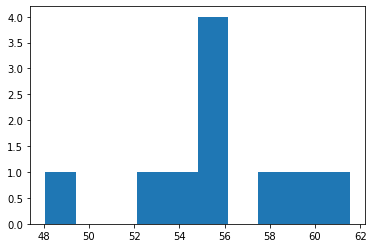

mean 55.57692307692307
stdev 3.5926041715902692


In [19]:
import matplotlib.pyplot as plt
test_accuracy = np.array(test_accuracy)
plt.hist(test_accuracy, bins=10)
plt.show()
mean = np.mean(test_accuracy)
print("mean", mean)
print("stdev", np.std(test_accuracy))